# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

17 campaigns were conducted between May 2008 and November 2010 with a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as PipelineImb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier

from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
import plotly.express as px
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df = df.rename(columns={"y": "subscribed"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
df_null = df.isnull().sum().sort_values().reset_index()
df_null.columns = ['Feature', 'Count']
df_null['%'] = round(df_null['Count'] / len(df)* 100, 2 )
df_null

Feature  Count    %
0              age      0  0.0
1        euribor3m      0  0.0
2    cons.conf.idx      0  0.0
3   cons.price.idx      0  0.0
4     emp.var.rate      0  0.0
5         poutcome      0  0.0
6         previous      0  0.0
7            pdays      0  0.0
8         campaign      0  0.0
9      nr.employed      0  0.0
10        duration      0  0.0
11           month      0  0.0
12         contact      0  0.0
13            loan      0  0.0
14         housing      0  0.0
15         default      0  0.0
16       education      0  0.0
17         marital      0  0.0
18             job      0  0.0
19     day_of_week      0  0.0
20      subscribed      0  0.0

Text(0, 0.5, '% Null')

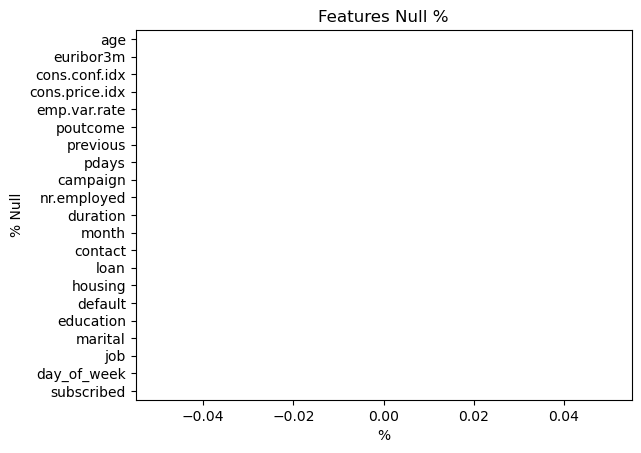

In [9]:
sns.barplot(data = df_null, y = 'Feature', x = '%')
plt.title('Features Null %')
plt.xticks(rotation=0)
plt.ylabel('% Null')

In this dataset there are no null values to correct.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The main task to be performed in this particular case is to understand what makes a customer accept or not to subscribe to a bank account (deposit) and to verify which are the characteristics that most influence this decision. For this purpose, a dataset of 41187 records has been provided from which information has been collected on several characteristics related to the customer.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

<h4 style="color:Blue">Imbalance</h4> 

subscribed  proportion
0         no    0.887346
1        yes    0.112654

Text(0, 0.5, 'Proportion')

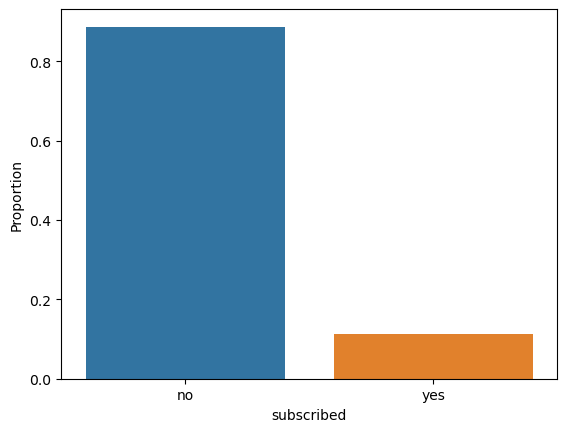

In [10]:
values_ct = df['subscribed'].value_counts(normalize = True)
values_ct = values_ct.reset_index()
display(values_ct)
sns.barplot(values_ct, x = 'subscribed', y = 'proportion')
plt.ylabel('Proportion')

As can be seen, the target variable is very unbalanced, which may affect the predictions.

In [11]:
df['subscribed'] = np.where(df['subscribed'] == 'yes', 1, 0)

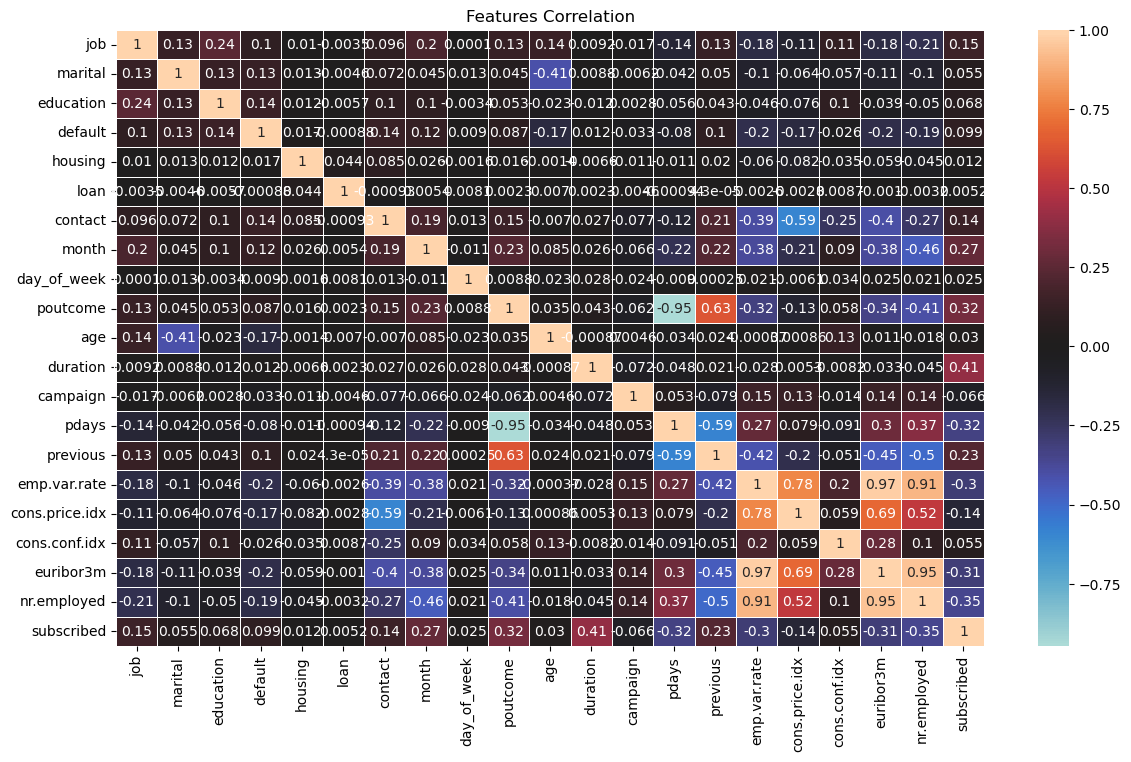

In [12]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
trg_enc = TargetEncoder()

churn_corr = pd.concat([trg_enc.fit_transform(df[cats] , df["subscribed"]), 
                          df[['age', 'duration','campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed']
                       ]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(churn_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');


There are several characteristics with a high correlation ('emp.var.rate', 'cons.price.idx', 'nr.employed')

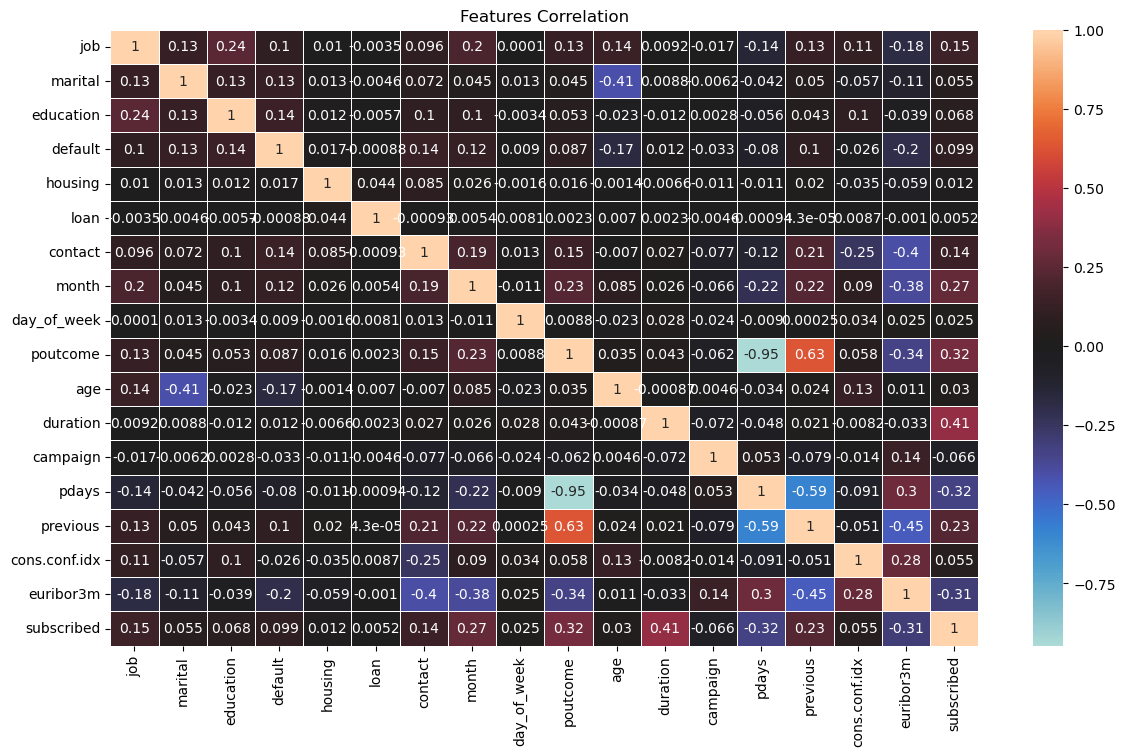

In [13]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
trg_enc = TargetEncoder()

churn_corr = pd.concat([trg_enc.fit_transform(df[cats] , df["subscribed"]), 
                          df[['age', 'duration','campaign', 'pdays', 'previous', 'cons.conf.idx', 'euribor3m', 'subscribed']
                       ]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(churn_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');


Highly correlated features are marked for removal.  

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

To start with we will use only the 7 features with customer information and train basic models with them.

In [14]:
X = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
y = df['subscribed']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train)
display(y_train)

age          job  marital            education  default housing loan
39075   29       admin.  married    university.degree       no      no   no
34855   29   technician   single    university.degree       no      no   no
7107    45  blue-collar  married             basic.6y  unknown     yes   no
31614   34     services  married    university.degree       no      no   no
34878   32       admin.   single          high.school       no      no   no
...    ...          ...      ...                  ...      ...     ...  ...
6265    58      retired  married  professional.course  unknown      no   no
11284   37   management  married    university.degree       no      no   no
38158   35       admin.  married          high.school       no     yes   no
860     40   management  married    university.degree       no     yes   no
15795   29       admin.   single    university.degree       no     yes   no

[28831 rows x 7 columns]

39075    0
34855    0
7107     0
31614    0
34878    0
        ..
6265     0
11284    0
38158    1
860      0
15795    0
Name: subscribed, Length: 28831, dtype: int32

variables to store score data

In [16]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
method = []

utility methods to visualize graphs

In [17]:
def getConfusionMatrix(y_test, y_test_pred, display_labels):
    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=display_labels)
    disp.plot()
    plt.show()

In [18]:
def getScores(y_test, y_test_pred):
    ps = precision_score(y_test, y_test_pred)
    rc = recall_score(y_test, y_test_pred)
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    scores = pd.DataFrame({'Scores':['Precision', 'Recall', 'Accuracy', 'F1'], 'Values' : [ps, rc, acc, f1]})
    display(scores)
    sns.barplot(scores, x = 'Scores', y = 'Values')
    return (ps, rc, acc, f1)

In [19]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    axis.grid()
    plt.title('Lift Curve')
    plt.show()

In [20]:
def getCurves(X_test, estimator):
    test_predictions = estimator.predict_proba(X_test)
    y_lb_test = np.where(y_test == 1, 'Subscribed', 'Not subscribed')
    ig, ax = plt.subplots(1, 2)
    #fig.set_size_inches(12, 12)
    
    fpr, tpr, thresh_rocs = roc_curve(y_lb_test, test_predictions[:, 1], pos_label='Subscribed')
    roc_auc_value = skcauc(fpr, tpr)
    roc_plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    roc_plt.plot(ax=ax[0])
    ax[0].grid()
    precision, recall, boundaries = precision_recall_curve(y_lb_test, test_predictions[:, 1], pos_label='Subscribed')
    pre_rec_plot = PrecisionRecallDisplay(precision=precision, recall=recall)
    pre_rec_plot.plot(ax=ax[1])
    ax[1].grid()    

    plot_lift_curve(y_test, y_test_pred)

In [21]:
def createBarColorfulPlot(data, title, x_name, y_name, x_label, y_label, rotation = 45):
    # Plotting
    plt.figure(figsize=(12, 6))  # Optional: Adjusts the size of the plot
    ax = sns.barplot(data=data, x=x_name, y=y_name, palette = 'cool')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Get current axis tick labels
    xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
    ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]
    
    # Capitalize each label
    capitalized_labels = [label.capitalize() for label in xlabels]

    # Set the modified labels back on the x-axis
    plt.gca().set_xticklabels(capitalized_labels)

    plt.xticks(rotation=rotation)
    
    # Despine the plot and show the final result
    sns.despine()
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"{title}.png", dpi=300)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

A dummy classifier will be used as a baseline reference model.

In [22]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

dm_pipe = Pipeline([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', DummyClassifier(strategy="uniform"))
    ])

dm_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('stdscl', StandardScaler()),
                ('model', DummyClassifier(strategy='uniform'))])

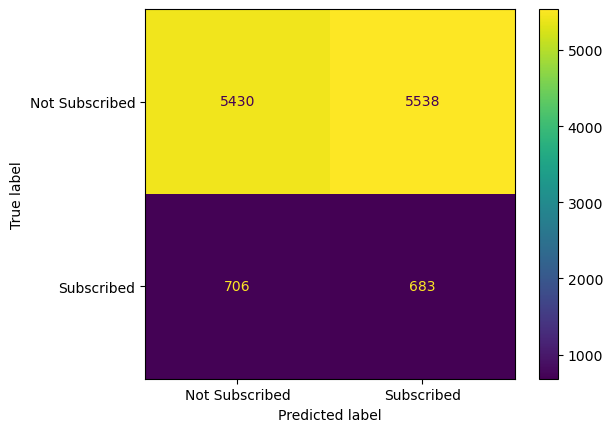

Scores    Values
0  Precision  0.109789
1     Recall  0.491721
2   Accuracy  0.494699
3         F1  0.179501

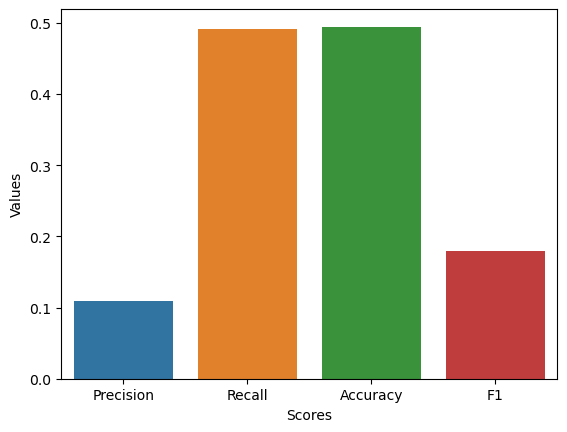

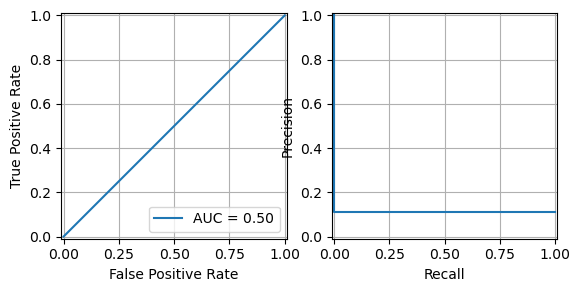

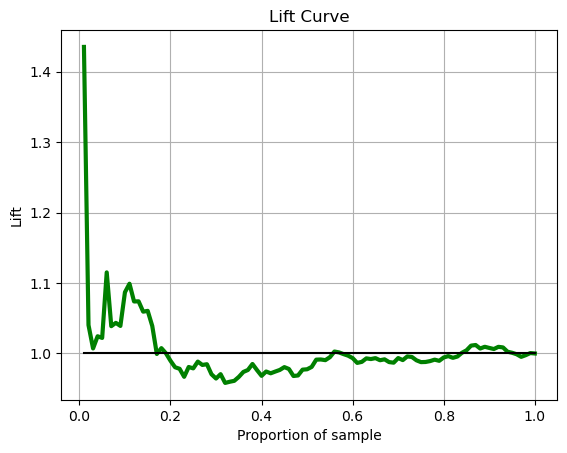

In [23]:
start = time.time()

best_est = dm_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Dummy Classifier')

as we can see the dummy classifier has a baseline which indicates that it is practically guessing

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [24]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

lr_pipe = PipelineImb([
        ('tranform', transf),
        ('model', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state=42, max_iter = 1000))
    ])

lr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

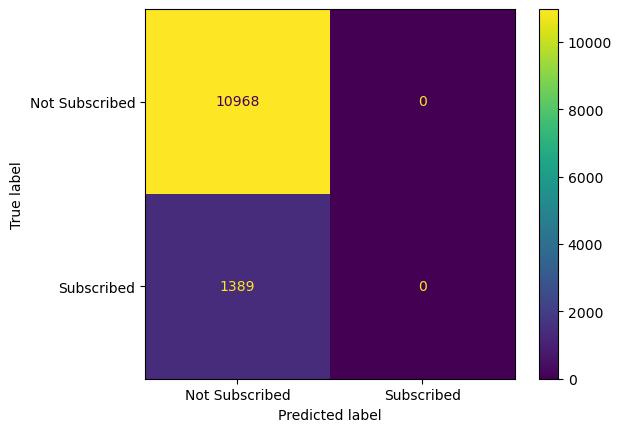

Scores    Values
0  Precision  0.000000
1     Recall  0.000000
2   Accuracy  0.887594
3         F1  0.000000

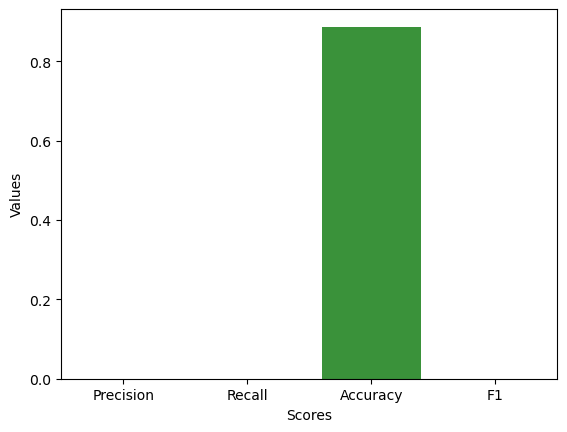

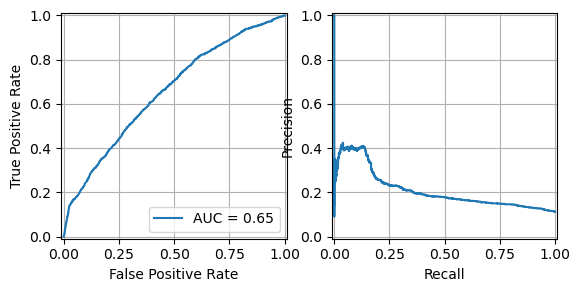

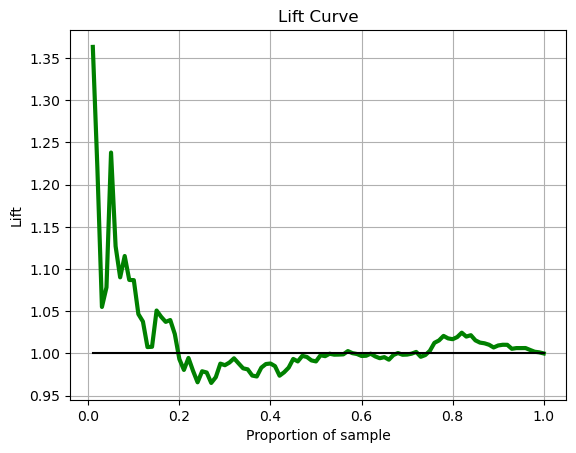

In [25]:
start = time.time()

best_est = lr_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Logistic Regression')


### Problem 9: Score the Model

What is the accuracy of your model?

In [26]:
print(f'The accuracy is {accuracy_list[1]}')

The accuracy is 0.8875940762320952


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

<h4 style="color:Blue">KNN</h4> 

In [27]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

k_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model',KNeighborsClassifier())
    ])

k_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('stdscl', StandardScaler()),
                ('model', KNeighborsClassifier())])

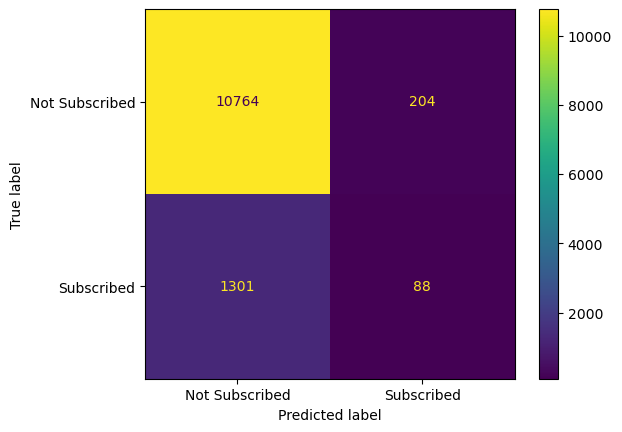

Scores    Values
0  Precision  0.301370
1     Recall  0.063355
2   Accuracy  0.878207
3         F1  0.104700

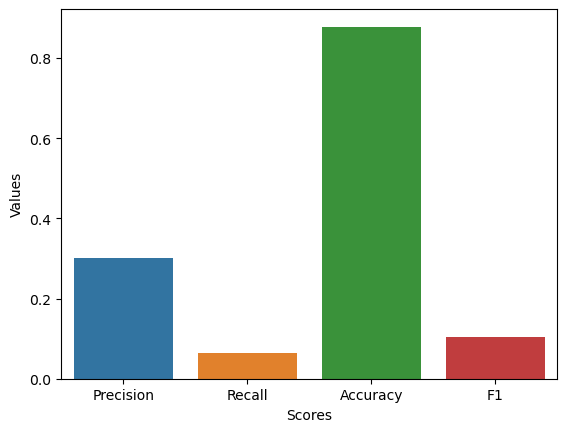

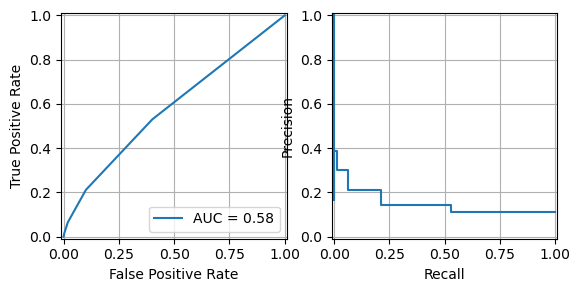

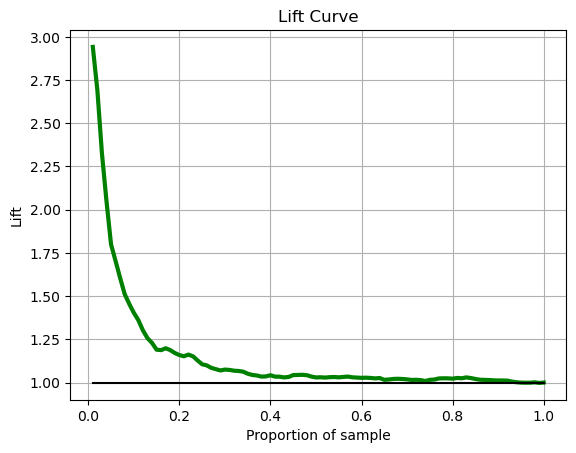

In [28]:
start = time.time()

best_est = k_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('KNN')

<h4 style="color:Blue">Decision Tree</h4> 

In [29]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

t_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', DecisionTreeClassifier(random_state=42))
    ])

t_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('stdscl', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=42))])

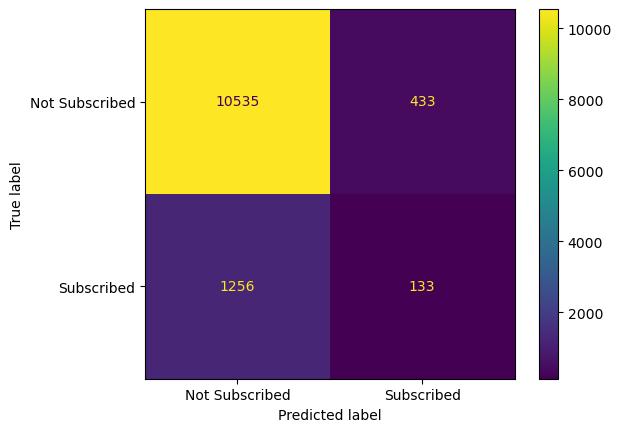

Scores    Values
0  Precision  0.234982
1     Recall  0.095752
2   Accuracy  0.863316
3         F1  0.136061

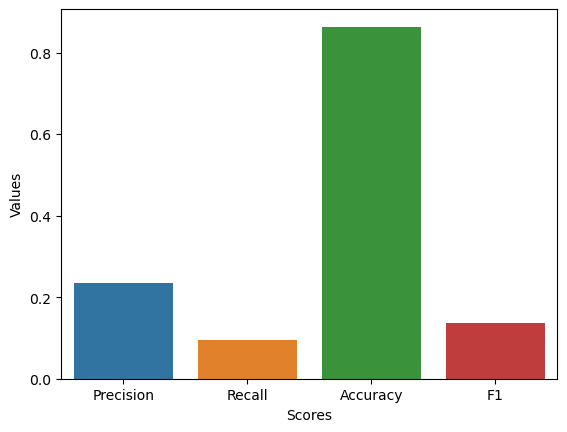

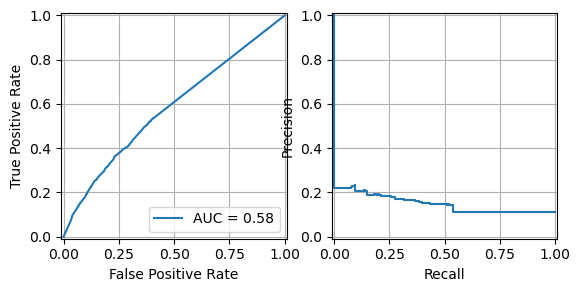

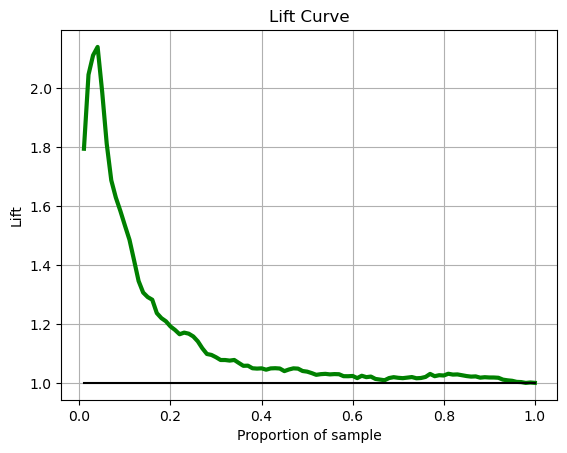

In [30]:
start = time.time()

best_est = t_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Decision Tree')

<h4 style="color:Blue">SVM</h4> 

In [31]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

svr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', SVC(probability=True, coef0=1, gamma='scale', kernel = 'rbf'))
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('stdscl', StandardScaler()),
                ('model', SVC(coef0=1, probability=True))])

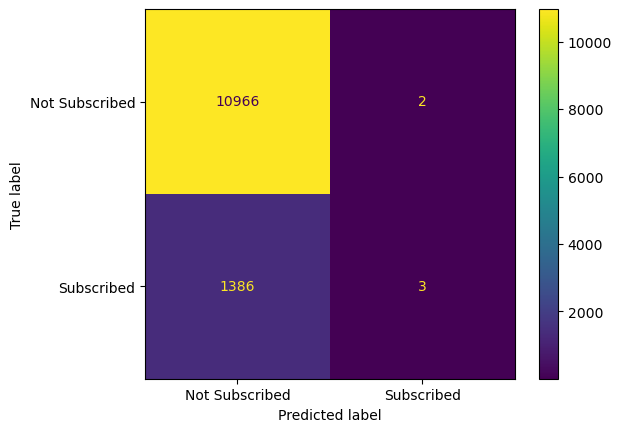

Scores    Values
0  Precision  0.600000
1     Recall  0.002160
2   Accuracy  0.887675
3         F1  0.004304

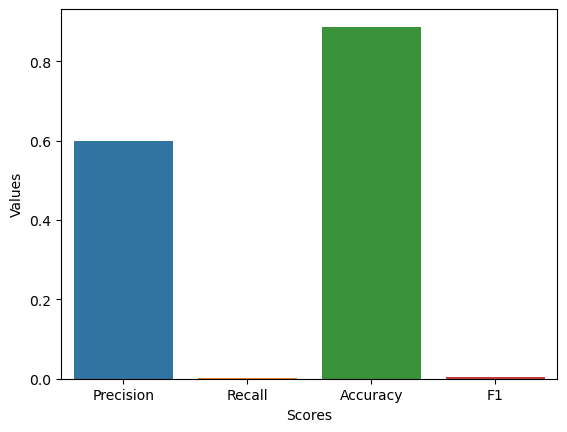

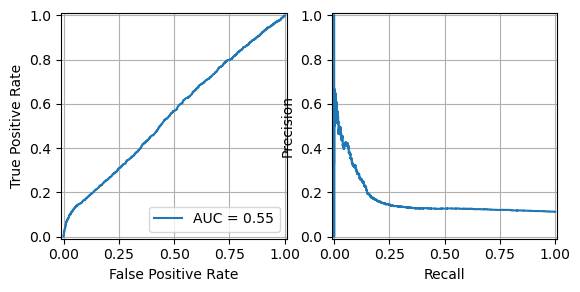

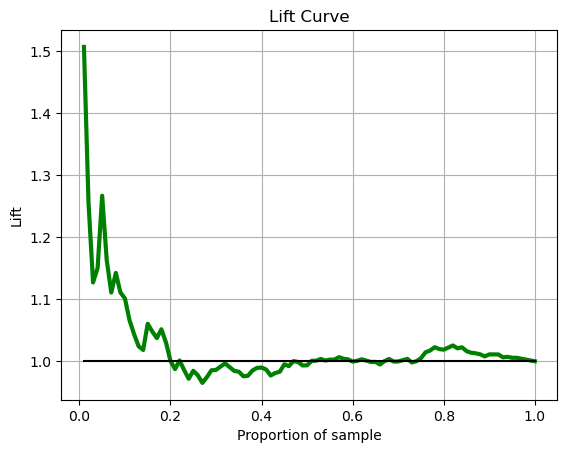

In [32]:
start = time.time()

best_est = svr_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('SVM')

<h4 style="color:Blue">Results</h4>

In [33]:
results_t1 = pd.DataFrame({'Method': method, 'Accuracy': accuracy_list, 'Recall': recall_list, 'Precision': precision_list, 'F1' : f1_list, 'Time (Sec)' : time_list})
results_t1

Method  Accuracy    Recall  Precision        F1  Time (Sec)
0     Dummy Classifier  0.494699  0.491721   0.109789  0.179501    0.086085
1  Logistic Regression  0.887594  0.000000   0.000000  0.000000    0.560003
2                  KNN  0.878207  0.063355   0.301370  0.104700    0.112599
3        Decision Tree  0.863316  0.095752   0.234982  0.136061    0.119615
4                  SVM  0.887675  0.002160   0.600000  0.004304   91.794466

<Axes: xlabel='Method'>

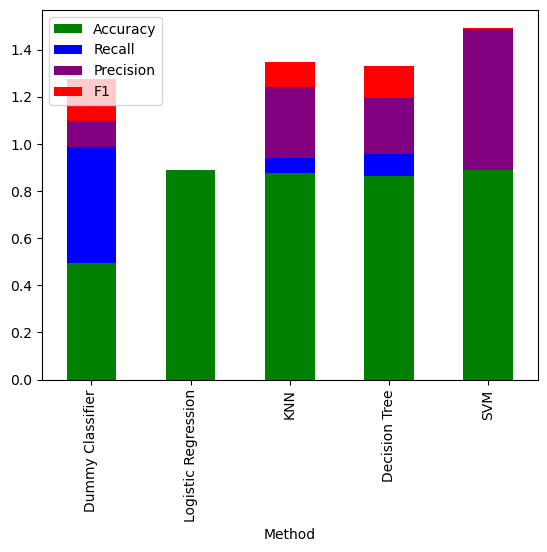

In [34]:
colors = ['green', 'blue', 'purple', 'red']
results_t1.drop('Time (Sec)', axis = 1).set_index('Method').plot(kind='bar', stacked=True, color=colors)

These results show that the best method for this specific dataset is Decision Tree since it has a good training time and in addition to a good accuracy(not the highest but close) it also has the highest F1 score. These models using only 7 characteristics are not ideal for prediction, they are too close to the base model (Dummy Classifier), it is notorious that it is necessary to add more characteristics to them.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In the correlation analysis some features were eliminated which had a high correlation between them, among those eliminated are the following: 

* emp.var.rate
* cons.price.idx
* nr.employed

In addition, the duration feature has also been removed, since as the column instructions indicate, this feature is set to zero before contacting a customer and it does not make sense to use it as a prediction feature.

We add the other characteristics that we omitted in the previous point except for those mentioned in the previous paragraph.

now to perform a deeper analysis we will use GridSearchCV to find the best parameters for each method.

In [35]:
X = df.drop(['subscribed', 'emp.var.rate', 'cons.price.idx', 'nr.employed', 'duration'], axis = 1)
y = df['subscribed']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
X_train

age            job   marital            education  default housing  \
10944   29  self-employed   married  professional.course       no      no   
21196   37     technician   married    university.degree       no      no   
24943   36     technician   married          high.school       no      no   
420     57    blue-collar   married             basic.4y  unknown     yes   
34036   33         admin.    single    university.degree       no     yes   
...    ...            ...       ...                  ...      ...     ...   
11532   31    blue-collar   married             basic.6y       no      no   
27640   49   entrepreneur   married    university.degree       no     yes   
14501   26         admin.    single    university.degree       no     yes   
30727   41    blue-collar   married             basic.9y       no      no   
11590   35     management  divorced          high.school       no     yes   

      loan    contact month day_of_week  campaign  pdays  previous  \
10944   no  telephone   jun         wed         1    999         0   
21196   no   cellular   aug         mon         2    999         0   
24943   no   cellular   nov         tue         2    999         1   
420     no  telephone   may         tue         1    999         0   
34036   no   cellular   may         wed         3    999         0   
...    ...        ...   ...         ...       ...    ...       ...   
11532   no  telephone   jun         fri         5    999         0   
27640   no   cellular   nov         fri         2    999         0   
14501   no   cellular   jul         tue         5    999         0   
30727   no   cellular   may         tue         1    999         0   
11590   no  telephone   jun         fri         4    999         0   

          poutcome  cons.conf.idx  euribor3m  
10944  nonexistent          -41.8      4.962  
21196  nonexistent          -36.1      4.963  
24943      failure          -42.0      4.153  
420    nonexistent          -36.4      4.857  
34036  nonexistent          -46.2      1.281  
...            ...            ...        ...  
11532  nonexistent          -41.8      4.959  
27640  nonexistent          -42.0      4.021  
14501  nonexistent          -42.7      4.961  
30727  nonexistent          -46.2      1.344  
11590  nonexistent          -41.8      4.959  

[28831 rows x 16 columns]

<h4 style="color:Blue">Logistic Regression Grid</h4> 

In [37]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

lr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state=42, max_iter = 1000))
    ])

lr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

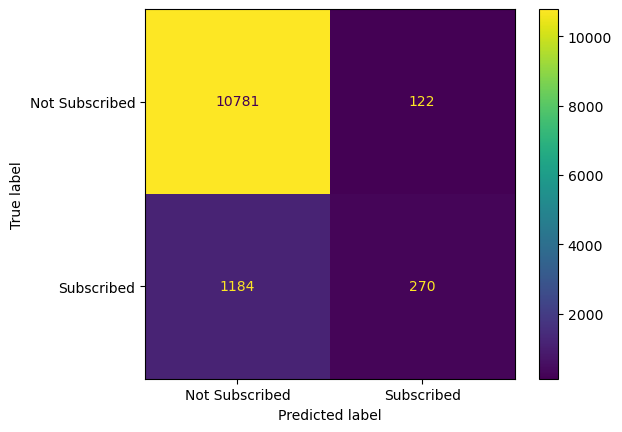

Scores    Values
0  Precision  0.688776
1     Recall  0.185695
2   Accuracy  0.894311
3         F1  0.292524

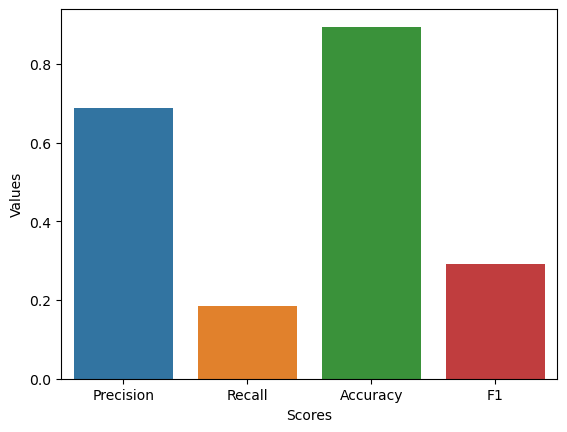

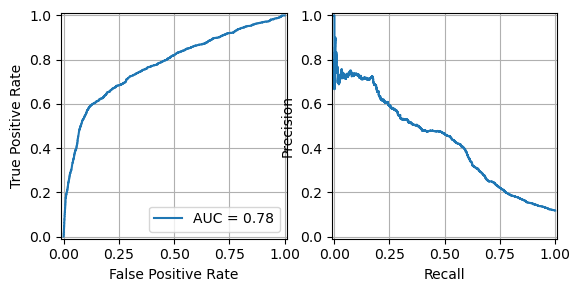

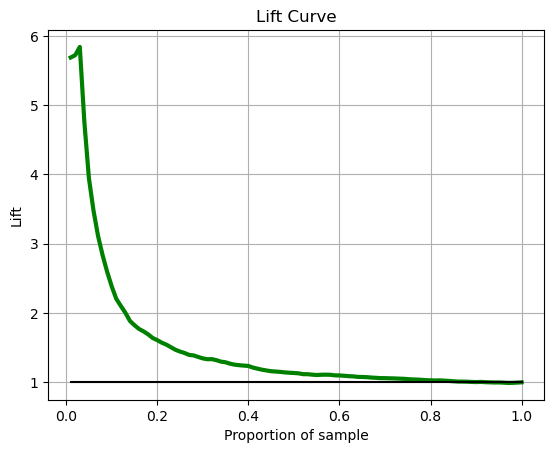

In [38]:
start = time.time()

params = {'model__C': np.logspace(-5, .5)}
grid = GridSearchCV(lr_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
#best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Logistic Regression Grid')

<h4 style="color:Blue">KNN Grid</h4> 

In [39]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

k_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model',KNeighborsClassifier())
    ])

k_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', KNeighborsClassifier())])

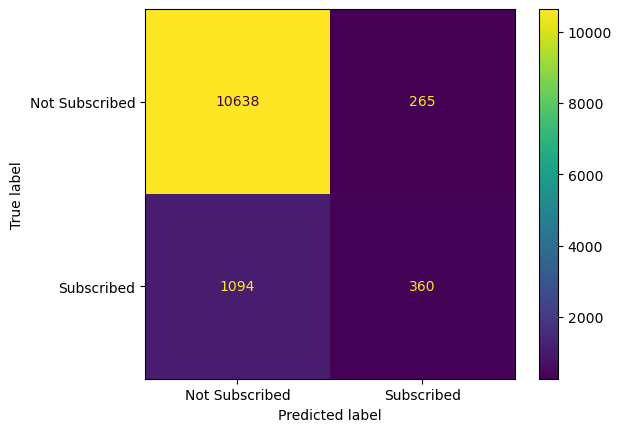

Scores    Values
0  Precision  0.576000
1     Recall  0.247593
2   Accuracy  0.890022
3         F1  0.346320

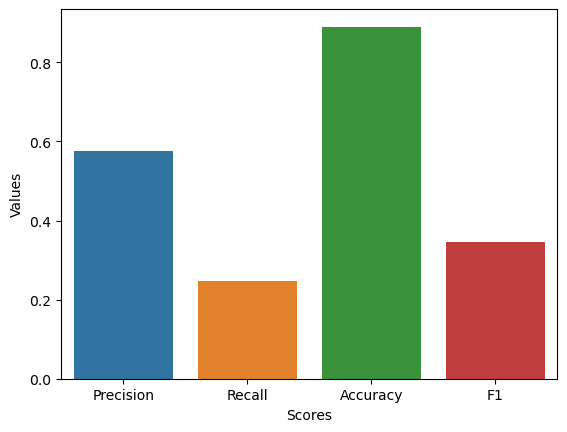

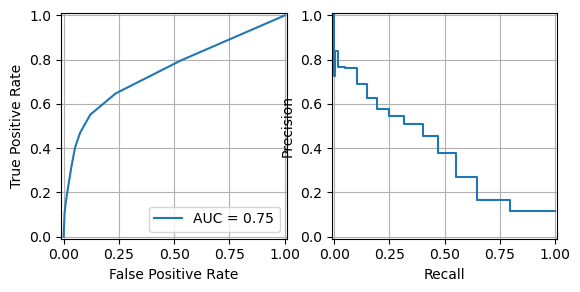

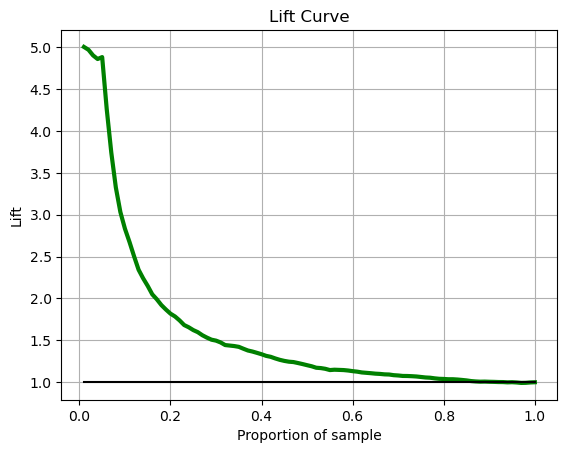

In [40]:
start = time.time()

params = {'model__n_neighbors': range(5, 22, 2)}
grid = GridSearchCV(k_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
#best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('KNN Grid')

<h4 style="color:Blue">Decision Tree Grid</h4> 

In [41]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

t_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', DecisionTreeClassifier(random_state=42))
    ])

t_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=42))])

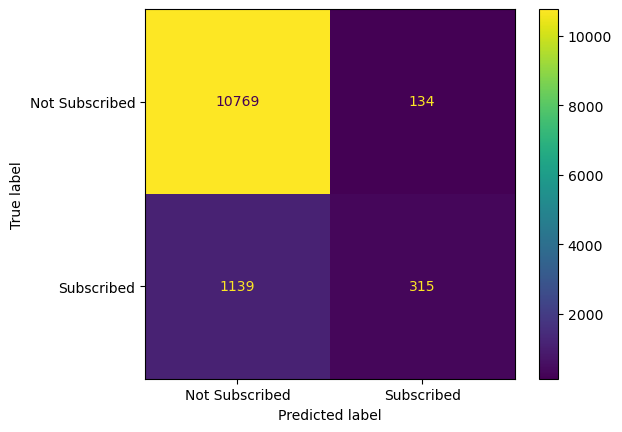

Scores    Values
0  Precision  0.701559
1     Recall  0.216644
2   Accuracy  0.896981
3         F1  0.331056

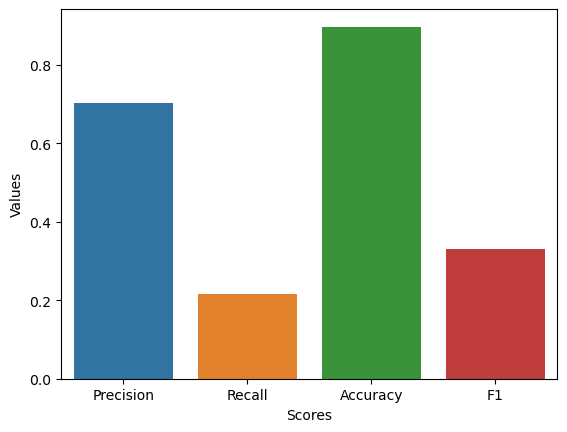

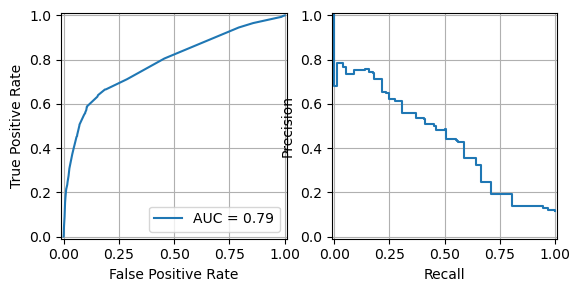

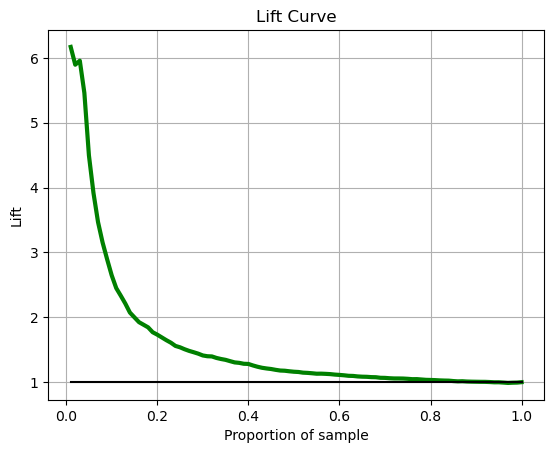

In [42]:
start = time.time()

params = {'model__max_depth': [1,2,3,4,5,6,7,8],
         'model__min_samples_split': [2,4,6,8],
          'model__criterion': ['gini', 'entropy'],
          'model__min_samples_leaf': [1,2,4,6]
         }
grid = GridSearchCV(t_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
#best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Decision Tree Grid')

<h4 style="color:Blue">SVM Poly Grid</h4> 

In [43]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

svr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', SVC(probability=True, coef0=1, gamma='scale', kernel='poly'))
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', SVC(coef0=1, kernel='poly', probability=True))])

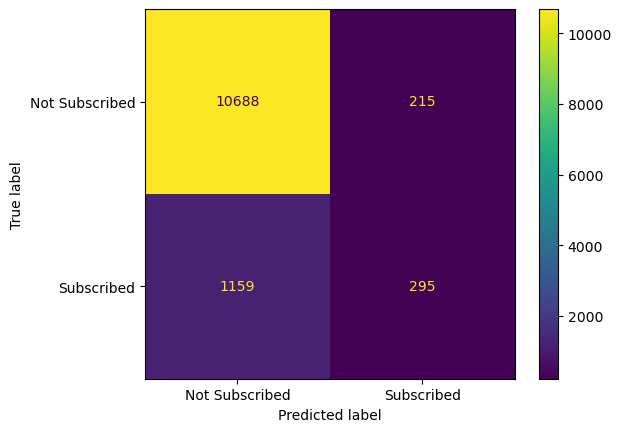

Scores    Values
0  Precision  0.578431
1     Recall  0.202889
2   Accuracy  0.888808
3         F1  0.300407

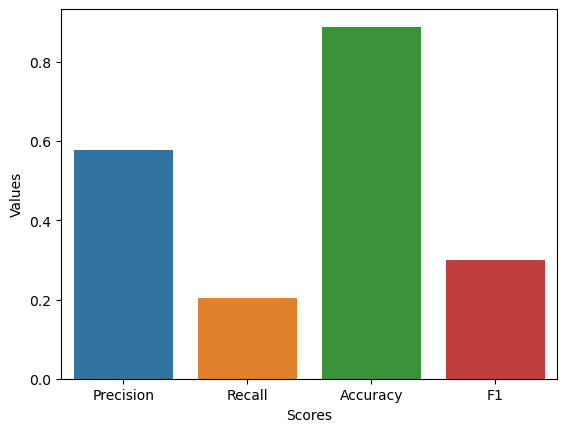

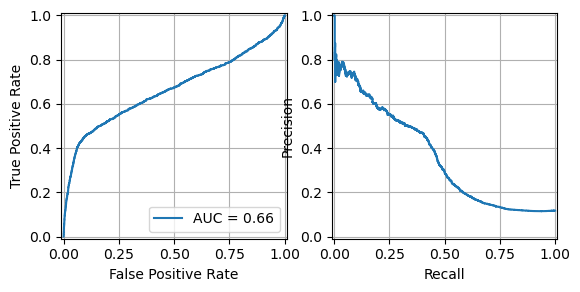

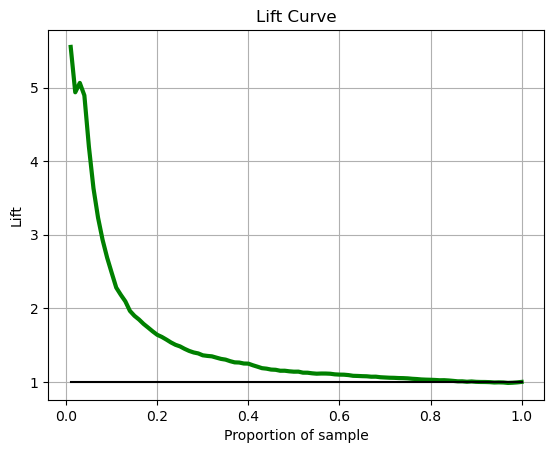

In [44]:
start = time.time()

params = {'model__degree' : [2,3,4]}
grid = HalvingRandomSearchCV(svr_pipe, param_distributions=params).fit(X_train, y_train)
best_est = grid.best_estimator_
#best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('SVM Poly Grid')

<h4 style="color:Blue">SVM Linear Grid</h4> 

In [45]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

svr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', CalibratedClassifierCV(LinearSVC(max_iter = 1000)))
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()),
                ('model', CalibratedClassifierCV(estimator=LinearSVC()))])

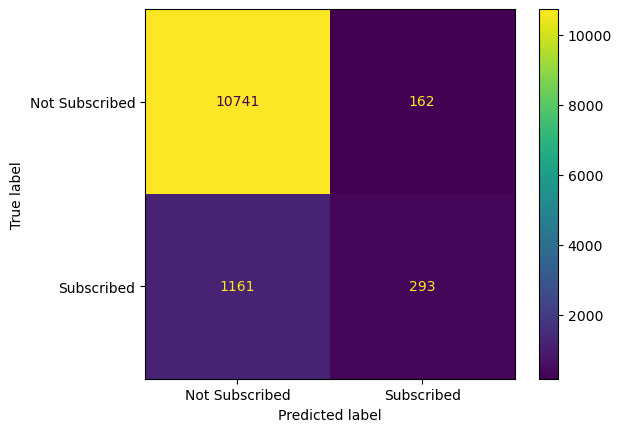

Scores    Values
0  Precision  0.643956
1     Recall  0.201513
2   Accuracy  0.892935
3         F1  0.306967

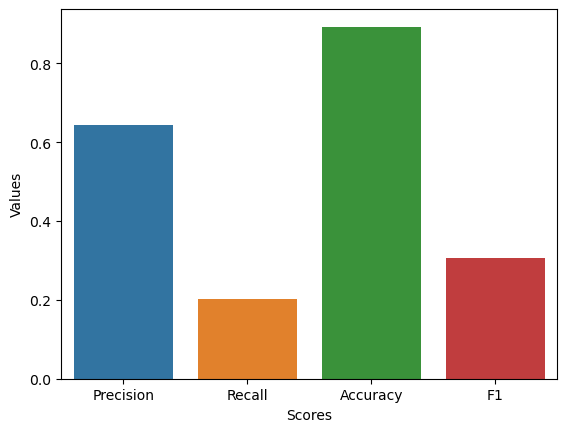

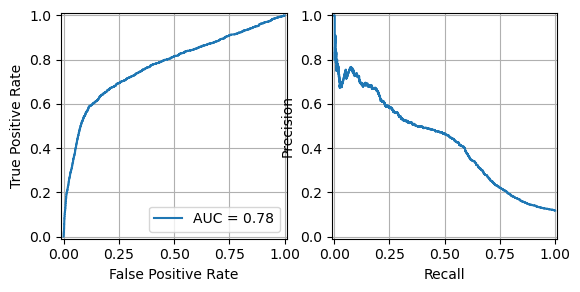

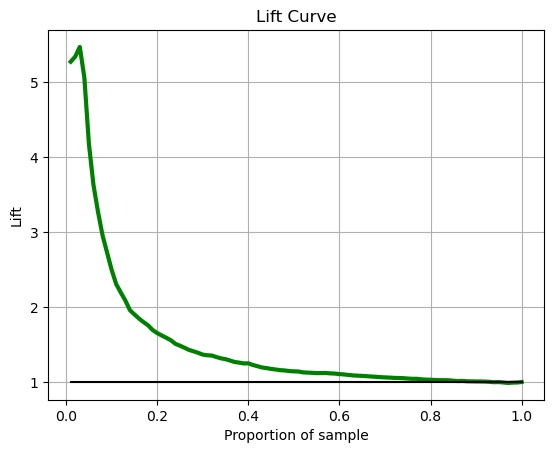

In [46]:
start = time.time()

best_est = svr_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('SVM Linear')

<h4 style="color:Blue">SGD Grid</h4> 

In [47]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

svr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', SGDClassifier(penalty='l2', max_iter = 1000))
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()), ('model', SGDClassifier())])

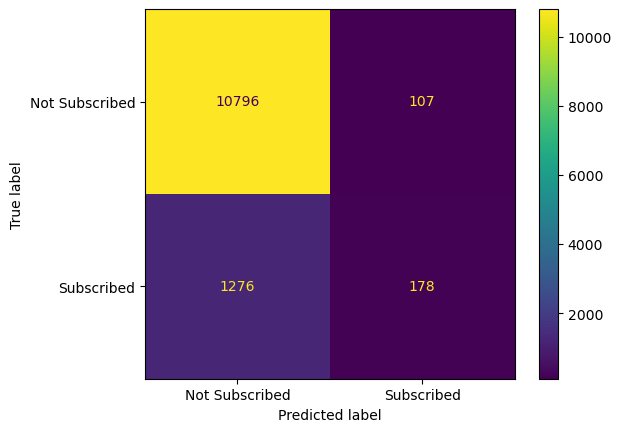

Scores    Values
0  Precision  0.624561
1     Recall  0.122421
2   Accuracy  0.888080
3         F1  0.204715

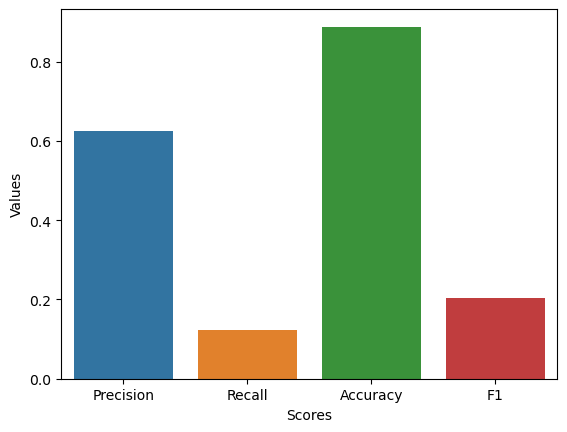

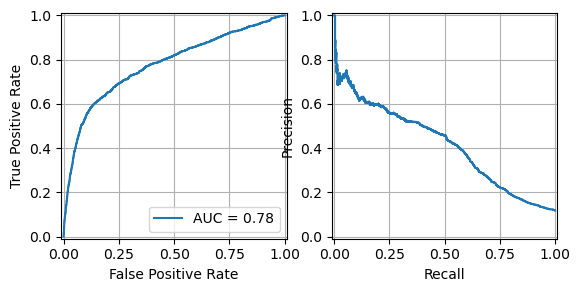

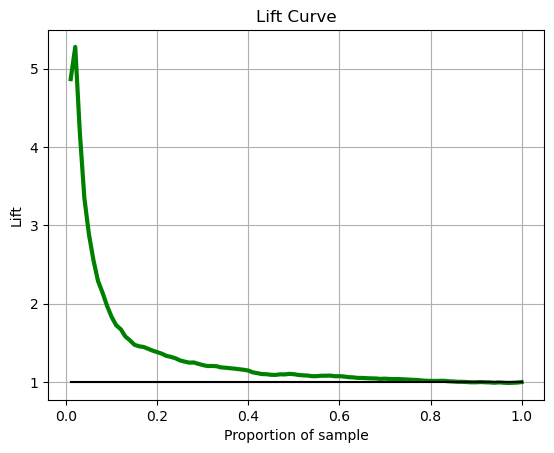

In [48]:
start = time.time()

params = {'model__loss': ['log_loss', 'modified_huber'],
         'model__alpha': [0.0001, 0.001]
         }
grid = GridSearchCV(svr_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_
#best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('SGD Grid')

In [49]:
grid.best_params_

{'model__alpha': 0.001, 'model__loss': 'log_loss'}

<h4 style="color:Blue">Decision Tree Oversampling</h4> 

In [50]:
cats = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

t_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', ADASYN()),
        ('model', DecisionTreeClassifier(random_state=42))
    ])

t_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', DecisionTreeClassifier(random_state=42))])

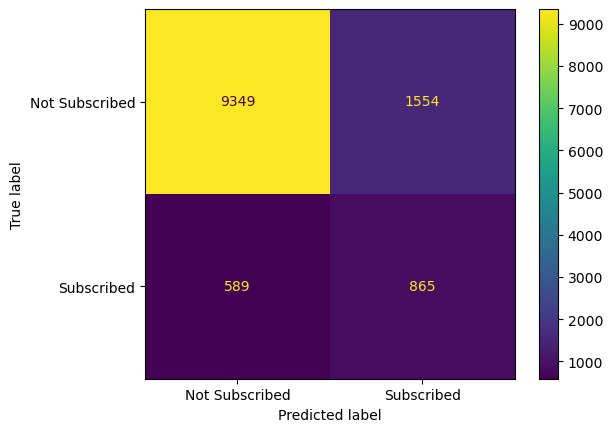

Scores    Values
0  Precision  0.357586
1     Recall  0.594911
2   Accuracy  0.826576
3         F1  0.446682

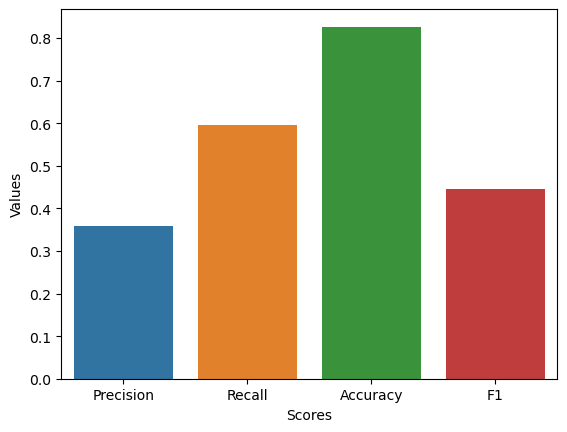

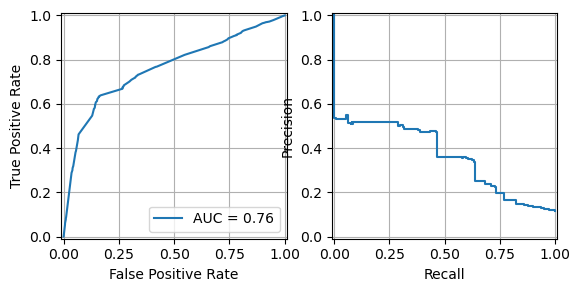

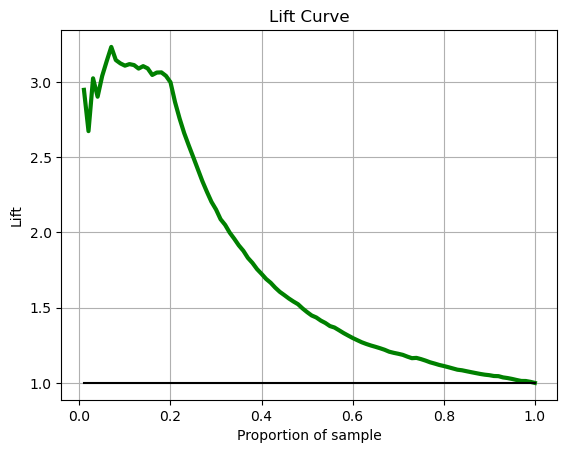

In [51]:
start = time.time()

params = {'model__max_depth': [1,2,3,4,5,6,7,8],
         'model__min_samples_split': [2,4,6,8],
          'model__criterion': ['gini', 'entropy'],
          'model__min_samples_leaf': [1,2,4,6]
         }
grid = GridSearchCV(t_pipe, param_grid=params).fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Subscribed', 'Subscribed'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Decision Tree Grid Over')
best_estimator_final = best_est

<h4 style="color:Blue">Results Grid</h4> 

In [52]:
results_t1 = pd.DataFrame({'Method': method, 'Accuracy': accuracy_list, 'Recall': recall_list, 'Precision': precision_list, 'F1' : f1_list, 'Time (Sec)' : time_list})
results_t1

Method  Accuracy    Recall  Precision        F1  \
0           Dummy Classifier  0.494699  0.491721   0.109789  0.179501   
1        Logistic Regression  0.887594  0.000000   0.000000  0.000000   
2                        KNN  0.878207  0.063355   0.301370  0.104700   
3              Decision Tree  0.863316  0.095752   0.234982  0.136061   
4                        SVM  0.887675  0.002160   0.600000  0.004304   
5   Logistic Regression Grid  0.894311  0.185695   0.688776  0.292524   
6                   KNN Grid  0.890022  0.247593   0.576000  0.346320   
7         Decision Tree Grid  0.896981  0.216644   0.701559  0.331056   
8              SVM Poly Grid  0.888808  0.202889   0.578431  0.300407   
9                 SVM Linear  0.892935  0.201513   0.643956  0.306967   
10                  SGD Grid  0.888080  0.122421   0.624561  0.204715   
11   Decision Tree Grid Over  0.826576  0.594911   0.357586  0.446682   

    Time (Sec)  
0     0.086085  
1     0.560003  
2     0.112599  
3     0.119615  
4    91.794466  
5    41.886756  
6    17.802621  
7   191.617767  
8   188.003663  
9     4.939630  
10    3.971995  
11  399.131329

<Axes: xlabel='Method'>

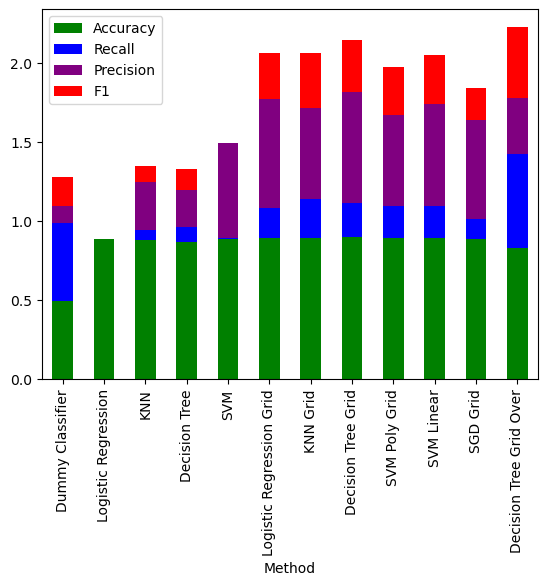

In [53]:
colors = ['green', 'blue', 'purple', 'red']
results_t1.drop('Time (Sec)', axis = 1).set_index('Method').plot(kind='bar', stacked=True, color=colors)

### Findings

As we can see after training several models with different parameters and different search techniques, Decision Tree together with ADASYN allows us to obtain a model with a higher f1 score than the others as well as an acceptable recall to handle false negatives. Furthermore, the ROC curve has an area of 0.75 but, although it is not the highest and is an acceptable value among the other models, we must keep in mind that this model has the highest recall(and f1 score) of all the others.

Decision tree using adasyn is the model with the highest F1 and recall value, a high recall means that the model correctly identifies most of the subscribers (minimizing false negatives). This is crucial if the cost of not identifying a subscriber is high. For example, if each subscribed user represents an important business opportunity, losing a subscriber due to a false negative can be very costly.

In conclusion, a high recall is generally better in a ranking algorithm to identify subscribed users, as it maximizes the detection of subscribed users and minimizes the risk of losing potential subscribers.

<h4 style="color:Blue">Feature Importances</h4> 

In [54]:
best_estimator_final = best_est
importances = permutation_importance(best_estimator_final, X_train, y_train, n_repeats = 10, random_state=40)

In [55]:
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
display(importances_tr)

import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

{'age': 0.001814019631646524,
 'job': 0.0,
 'marital': 0.00046477749644483477,
 'education': 0.0016093787936596548,
 'default': 0.0,
 'housing': 0.00039887620963549033,
 'loan': 0.0,
 'contact': 0.0023585723700184193,
 'month': 0.07380597273767824,
 'day_of_week': 0.022205265165967235,
 'campaign': 0.008764871145641884,
 'pdays': 0.0007595990426971566,
 'previous': 0.0001318025736187334,
 'poutcome': 0.00019770386042804454,
 'cons.conf.idx': 0.03717179424924564,
 'euribor3m': 0.1458291422427249}

{'euribor3m': 0.1458291422427249,
 'month': 0.07380597273767824,
 'cons.conf.idx': 0.03717179424924564,
 'day_of_week': 0.022205265165967235,
 'campaign': 0.008764871145641884,
 'contact': 0.0023585723700184193,
 'age': 0.001814019631646524,
 'education': 0.0016093787936596548,
 'pdays': 0.0007595990426971566,
 'marital': 0.00046477749644483477,
 'housing': 0.00039887620963549033,
 'poutcome': 0.00019770386042804454,
 'previous': 0.0001318025736187334,
 'job': 0.0,
 'default': 0.0,
 'loan': 0.0}

Importances
euribor3m         0.145829
month             0.073806
cons.conf.idx     0.037172
day_of_week       0.022205
campaign          0.008765
contact           0.002359
age               0.001814
education         0.001609
pdays             0.000760
marital           0.000465
housing           0.000399
poutcome          0.000198
previous          0.000132
job               0.000000
default           0.000000
loan              0.000000

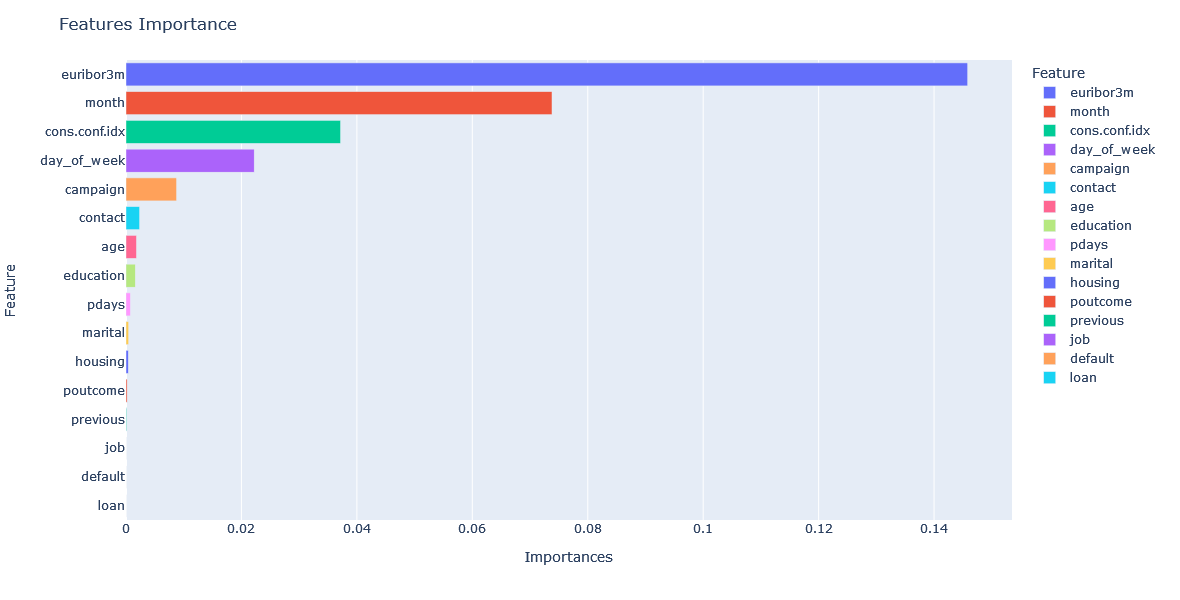

In [56]:
fig = px.bar(import_df.reset_index(), x="Importances", y = 'index', color='index', labels={'index' : 'Feature'})
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title="Features Importance"
)
fig.show()

As we can see Euribor is the feature that most influences a customer's acceptance of whether or not to sign up for a deposit, it is not surprising that this feature is above all others because if Euribor rises, reflecting a higher interest rate environment, it is very likely that banks will be able to increase interest rates on savings accounts to make them more attractive to depositors. This is especially true if banks rely heavily on customer deposits for funding, but, as a very important point to keep in mind, when interest rates are low, returns on other financial investments (such as bonds and time deposits) also tend to be low. In this environment, people may choose to open savings accounts as a low-risk strategy, protecting their capital while waiting for better investment opportunities.

The month and day are other characteristics that influence the decision to open a deposit or not, which is something to take into account because depending on the month and day it is very likely that customers will be more willing to open an account.

The consumer confidence index (cons.conf.idx) measures the degree of optimism consumers feel about the general state of the economy and their personal financial situation. This index can have a significant influence on individual's financial decisions, including the opening of savings accounts at a bank. 

And what would be the reason? 

When the consumer confidence index is high, consumers feel more confident about their future financial situation. This may lead them to feel less inclined to save cautiously and instead spend more on consumption and investments. That can create a high confidence environment, if the economy is expanding, banks may offer higher interest rates on savings accounts to attract more deposits and fund additional loans.

In contrast, if the consumer confidence index is low, consumers may be more concerned about economic uncertainty and, therefore, more inclined to save money to protect against possible future financial difficulties. This may result in an increase in the opening of savings accounts.

<h4 style="color:Blue">Features Analysis</h4> 

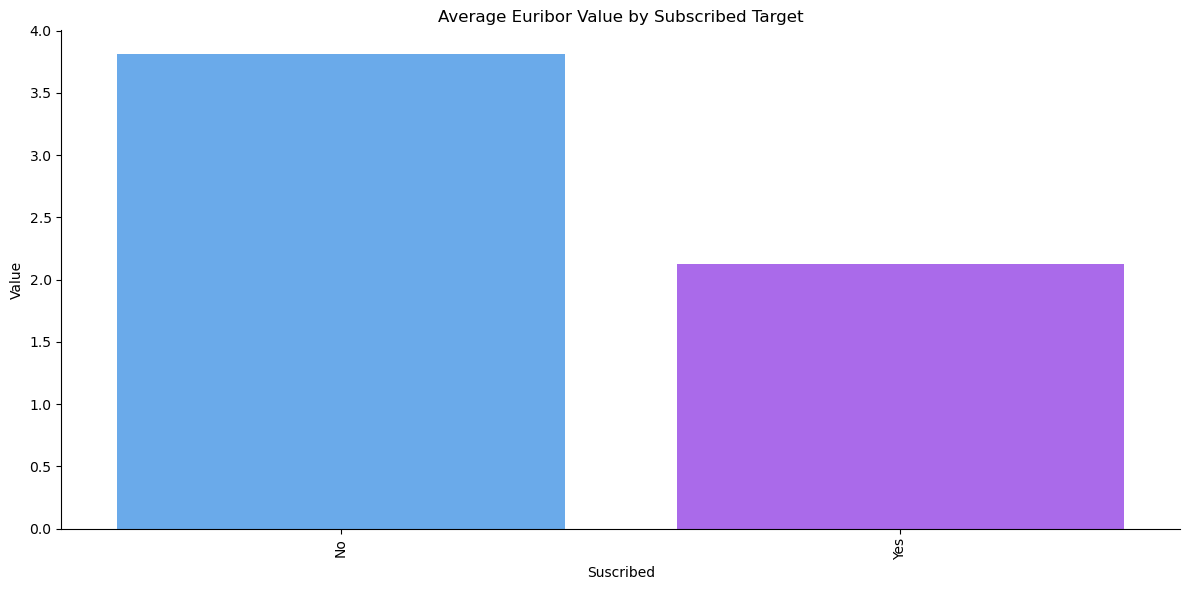

In [57]:
plot_data = df.groupby('subscribed')['euribor3m'].mean().reset_index()
plot_data = plot_data.sort_values(by='euribor3m', ascending=False)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')
plot_data
createBarColorfulPlot(plot_data, 'Average Euribor Value by Subscribed Target', 'subscribed', 'euribor3m', 'Suscribed', 'Value', 90)

This graph shows that the Euribor has a very important influence on the prediction of whether or not a client accepts to subscribe to a bank account. As can be seen the average Euribor is higher in customers who did not accept the deposit while in customers who did accept the deposit the Euribor is lower, so the conclusion here is that when the Euribor has a low value it is the best time to promote the bank's deposit accounts.

Banks may offer additional incentives to open savings accounts when Euribor is low. This may include account opening bonuses, promotional interest rates or additional services. These incentives may entice people to open new savings accounts.

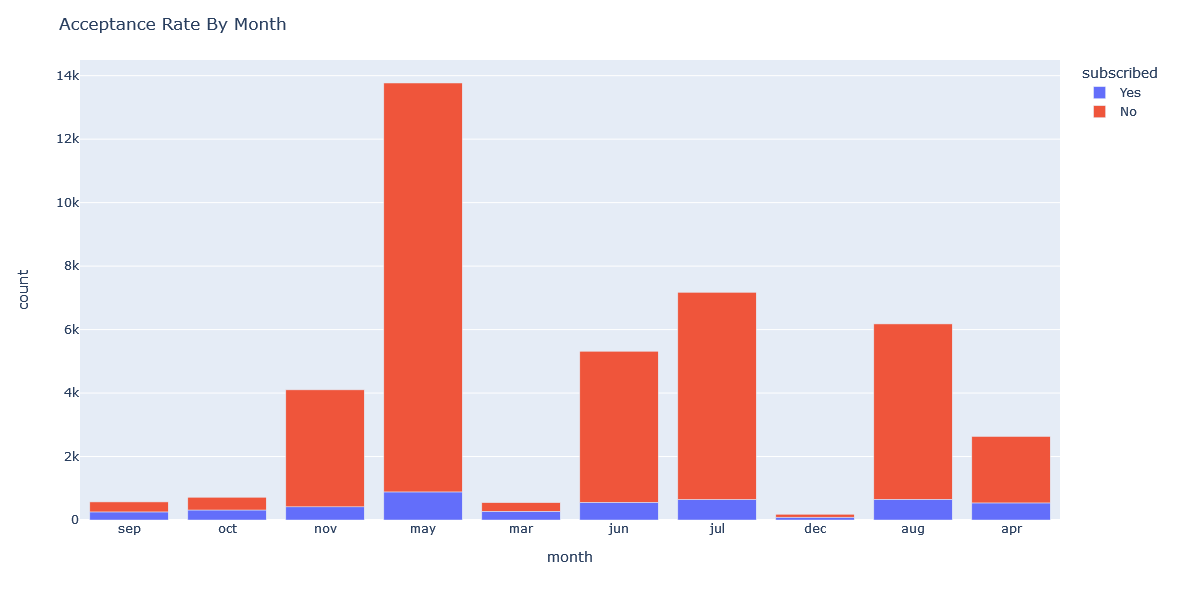

In [58]:
plot_data = df.groupby('month')['subscribed'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='month', ascending=False)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')


fig = px.bar(plot_data, x='month', y='count',
            color='subscribed')

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Acceptance Rate By Month"
)
fig.show()

As we can see some months have a higher activity than others in terms of customer contact (months like June or July), especially the month of May, but even though it was a month with the highest acceptance of customers to open a bank account, it has a much higher rejection rate than other months, while for example months like March, October or September are months with a more 50/50 rate and even though there are fewer calls and fewer subscribers accepting the deposit, it is a month that could present an opportunity to improve that positive acceptance with a lower rejection rate. 

This is probably because May, June or July in Europe are summer months and people would rather spend their money on vacation than on saving. With the exception of December which is a somewhat special month, some months are more likely to improve the acceptance of subscribing to a bank account if the above is taken into account.

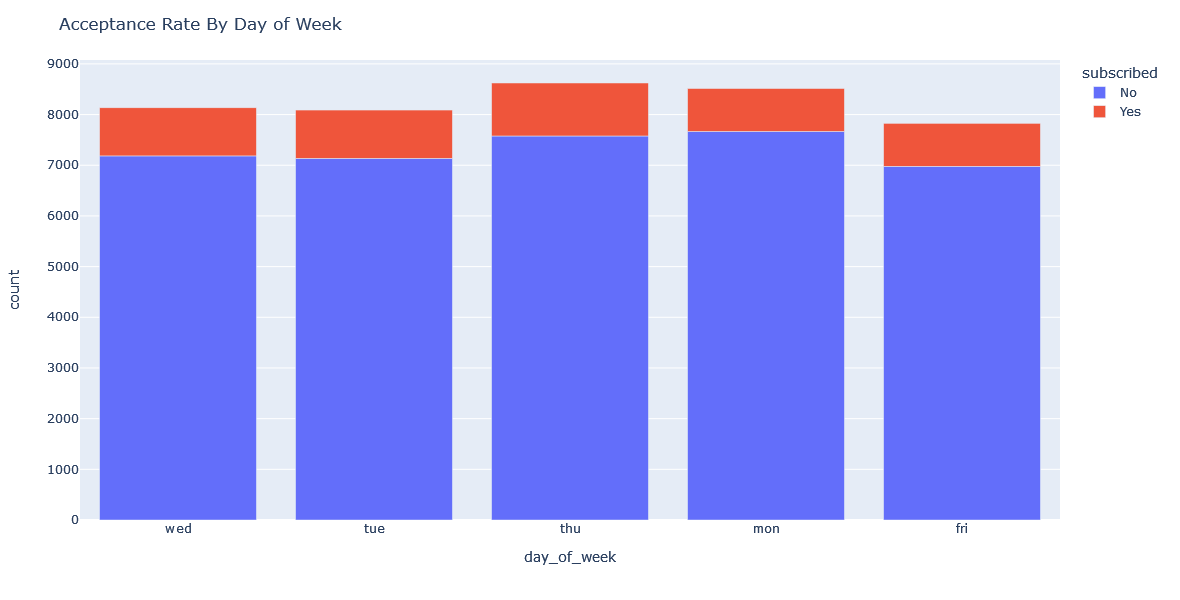

In [59]:
plot_data = df.groupby('day_of_week')['subscribed'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='day_of_week', ascending=False)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')
plot_data
fig = px.bar(plot_data, x='day_of_week', y='count',
            color='subscribed',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Acceptance Rate By Day of Week"
)
fig.show()

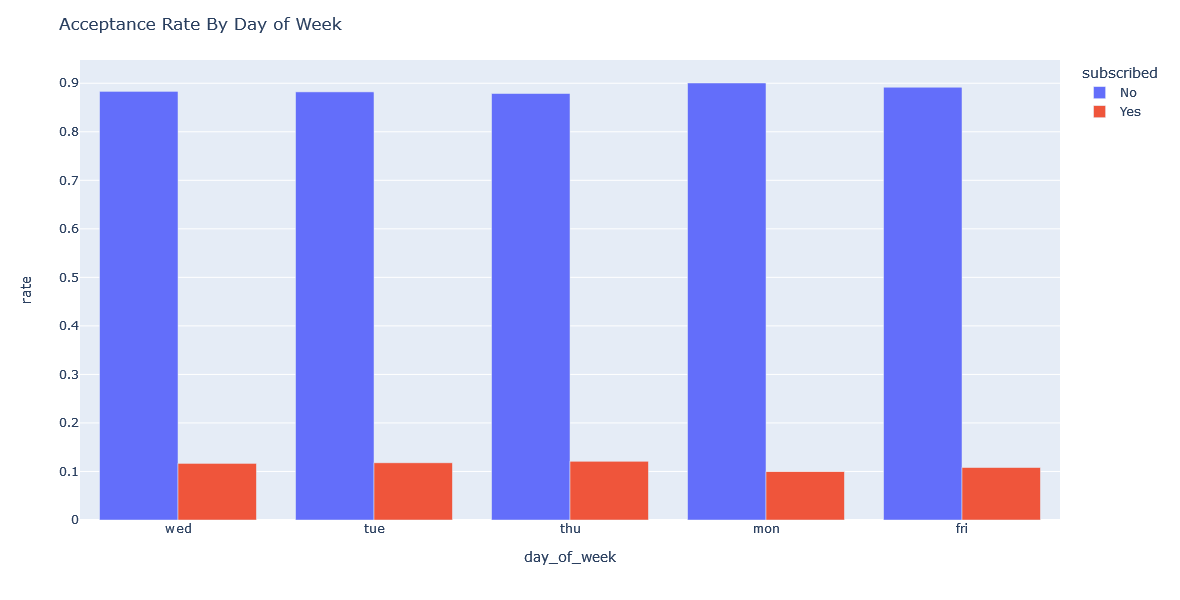

In [60]:
total_count = plot_data.groupby('day_of_week').sum().reset_index().drop('subscribed', axis = 1)
merge_count = plot_data.merge(total_count, left_on='day_of_week', right_on='day_of_week')
merge_count['rate'] = merge_count['count_x'] / merge_count['count_y']
merge_count = merge_count.drop(['count_x', 'count_y'], axis = 1)
fig = px.bar(merge_count, x='day_of_week', y='rate',
            color='subscribed',barmode='group',
            height=400)
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Acceptance Rate By Day of Week"
)
fig.show()

Although the data per day of the week are very similar, it is possible to rescue that Thursday has a slightly higher acceptance rate than the others, being Monday and Friday the ones with less acceptance, it is advisable that the calls can be made better on Wednesday and Thursday in order to improve the acceptance rate.

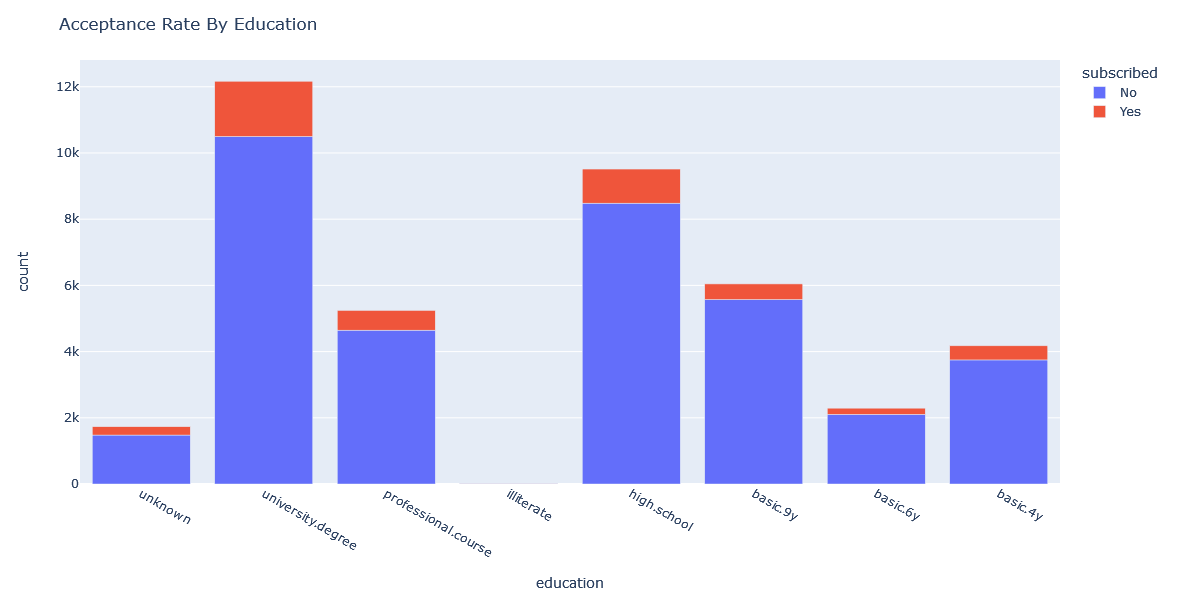

In [61]:
plot_data = df.groupby('education')['subscribed'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='education', ascending=False)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')
plot_data
fig = px.bar(plot_data, x='education', y='count',
            color='subscribed',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Acceptance Rate By Education"
)
fig.show()

Keep in mind that the highest acceptance comes from people with a university degree and similar. 

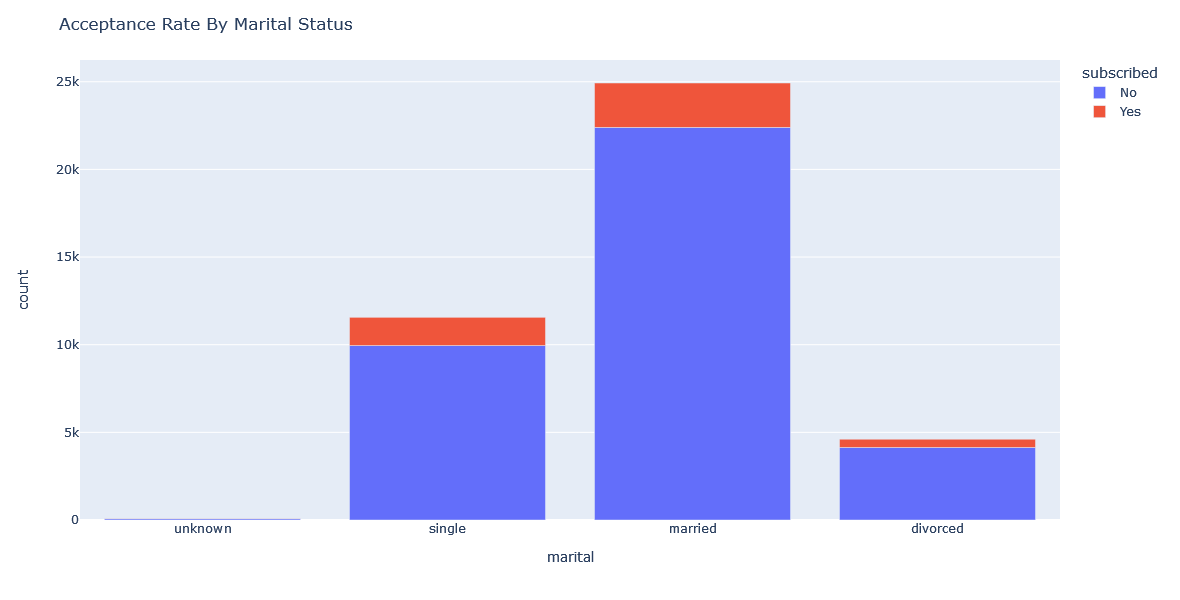

In [62]:
plot_data = df.groupby('marital')['subscribed'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='marital', ascending=False)
plot_data['subscribed'] = np.where(plot_data['subscribed'] == 1 , 'Yes', 'No')
plot_data
fig = px.bar(plot_data, x='marital', y='count',
            color='subscribed',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Acceptance Rate By Marital Status"
)
fig.show()

Married is the marital status most likely to accept subscription followed by single.

<h4 style="color:Blue">Next steps and recommendations</h4> 

* One way to improve this model is to perform an update of the data and increase the number of records to try to train a neural network to see if this type of model would improve prediction.
* It is more fruitful to offer bank account subscription services to people with higher levels of education.
* The Euribor is a very important feature to take into account, if interest rates go down it is the right time to carry out a campaign.
* Targeting people with a single or married marital status yields better results than targeting people with unknown or divorced marital status.
* It is more viable to offer banking and deposit services when the consumer confidence index is low.